# Reading Quiz
* 1) A
* 2) High-Bias, Low-Variance
* 3) C
* 4) Impossible to Tell
* 5) True
* 6) False
* 7) LN * cost(n-1,d)
* 8) 3 years
* 9) k=36

m1= graphlab.linear_regression.create(set_1, features=['bedrooms','bathrooms','sqft_living'], target='price', l2_penalty=l2_small_penalty)
tmpset_1= set_1.copy()
tmpset_1['bedrooms']= tmpset_1['bedrooms'].apply(lambda x: 2*x)
m2= graphlab.linear_regression.create(tmpset_1, features=['bedrooms','bathrooms','sqft_living'], target='price', l2_penalty=l2_small_penalty)
m1.get('coefficients').join(m2.get('coefficients'), on='name')

# Regression Week 4: Ridge Regression (interpretation)

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

We will continue to use the House data from previous notebooks.  (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)

# Fire up graphlab create

In [1]:
import graphlab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import log
from math import floor

# Polynomial regression, revisited

We build on the material from Week 3, where we wrote the function to produce an SFrame with columns containing the powers of a given input. Copy and paste the function `polynomial_sframe` from Week 3:

In [2]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    maxDegreeLength= int(floor(log(degree)))
    columnPrefix= 'power_'
    
    # initialize the SFrame:
    poly_sframe = graphlab.SFrame()
    
    # and set poly_sframe['power_1'] equal to the passed feature
    columnName= columnPrefix+'1'.zfill(maxDegreeLength)
    poly_sframe[columnName]= feature

    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = columnPrefix + str(power).zfill(maxDegreeLength)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name]= feature.apply(lambda x: x**power)

    return poly_sframe

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [3]:
sales = graphlab.SFrame('kc_house_data.gl/')

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\edwardsd\AppData\Local\Temp\3\graphlab_server_1484693782.log.0


This non-commercial license of GraphLab Create for academic use is assigned to david.edwards@act.org and will expire on September 14, 2017.


As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [4]:
sales = sales.sort(['sqft_living','price'])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [5]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights.

Hint: make sure to add 'price' column to the new SFrame before calling `graphlab.linear_regression.create()`. Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set=None` in this call.

In [6]:
data= polynomial_sframe(sales['sqft_living'],15)
data['price']= sales['price']

model = graphlab.linear_regression.create(data, 
                                          target='price', l2_penalty=l2_small_penalty,l1_penalty=0.,
                                          validation_set=None,verbose=False)

In [7]:
model.get('coefficients')

Columns:
	name	str
	index	str
	value	float
	stderr	float

Rows: 16

Data:
+-------------+-------+--------------------+-------------------+
|     name    | index |       value        |       stderr      |
+-------------+-------+--------------------+-------------------+
| (intercept) |  None |   167924.860299    |   797106.396828   |
|   power_01  |  None |   103.090940454    |   3991.82068676   |
|   power_02  |  None |   0.134604569621   |   8.20752558629   |
|   power_03  |  None | -0.000129071380882 |  0.00918775633583 |
|   power_04  |  None | 5.18929047414e-08  | 6.25432194219e-06 |
|   power_05  |  None | -7.7716959357e-12  | 2.72742130364e-09 |
|   power_06  |  None | 1.71145398227e-16  | 7.75838910285e-13 |
|   power_07  |  None | 4.51177396318e-20  | 1.41620252356e-16 |
|   power_08  |  None | -4.78837836601e-25 | 1.52858254308e-20 |
|   power_09  |  None | -2.33343414208e-28 | 7.24211827475e-25 |
+-------------+-------+--------------------+-------------------+
[16 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

***QUIZ QUESTION:  What's the learned value for the coefficient of feature `power_1`?***

###### Before 1/17/2017
* power_1 None	 -5945.50644886	 3988.81359538

###### On 1/17/2017
* power_1	None	103.090940454	3991.82068676

# Observe overfitting

Recall from Week 3 that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. We will see in a moment that ridge regression reduces such variance. But first, we must reproduce the experiment we did in Week 3.

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

In [8]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

Hint: When calling `graphlab.linear_regression.create()`, use the same L2 penalty as before (i.e. `l2_small_penalty`).  Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set = None` in this call.

In [9]:
datasets= [set_1, set_2, set_3, set_4]

# Method 1

In [10]:
featureCol= 'sqft_living'
maxDegree= 15
targetCol= 'price'
l2_penalty= l2_small_penalty

In [11]:
models=[]
for dataset in datasets:
    target= dataset.copy()
    data= polynomial_sframe(target[featureCol],maxDegree)
    data[targetCol]= target[targetCol]
    
    model= graphlab.linear_regression.create(data,
                                            target=targetCol,
                                            l2_penalty=l2_penalty,
                                            l1_penalty=0.,
                                            validation_set=None,
                                            verbose=False)
    models.append(model)

## Evaluate Method 1

In [12]:
allCoeff= graphlab.SFrame()
for i,m in enumerate(models):
    f= m.get('coefficients')
    f['model']= i
    allCoeff= allCoeff.append(f)

In [13]:
allCoeff.sort('name').head()

Columns:
	name	str
	index	str
	value	float
	stderr	float
	model	int

Rows: 10

Data:
+-------------+-------+-----------------+---------------+-------+
|     name    | index |      value      |     stderr    | model |
+-------------+-------+-----------------+---------------+-------+
| (intercept) |  None |  9306.46348004  | 900944.823086 |   0   |
| (intercept) |  None |  -170240.028629 | 1632166.30083 |   3   |
| (intercept) |  None |  462426.580985  | 1740562.78409 |   2   |
| (intercept) |  None |  -25115.8897145 | 1401834.06352 |   1   |
|   power_01  |  None |  585.865813792  | 3949.66696689 |   0   |
|   power_01  |  None |  1247.59033533  | 10667.8919582 |   3   |
|   power_01  |  None |  -759.251894247 | 8955.93484765 |   2   |
|   power_01  |  None |  783.493739085  | 7477.52911259 |   1   |
|   power_02  |  None | -0.767759205116 | 16.4818945916 |   1   |
|   power_02  |  None |  -1.2246091156  | 28.9022475886 |   3   |
+-------------+-------+-----------------+---------------+-------+
[10 rows x 5 columns]

# Plot the models

In [14]:
for i,m in enumerate(models):
    colName= "model"+str(i)
    sales[colName]= m.predict(polynomial_sframe(sales['sqft_living'],15))

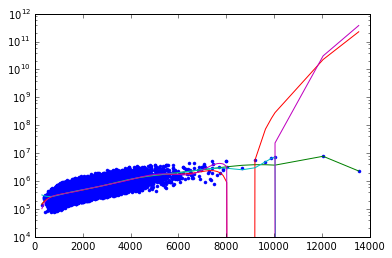

In [15]:
plt.plot(sales['sqft_living'], sales['price'], '.')
for i,m in enumerate(models):
    colName= "model"+str(i)
    plt.plot(sales['sqft_living'], sales[colName],'-')

plt.yscale('log')
plt.show()

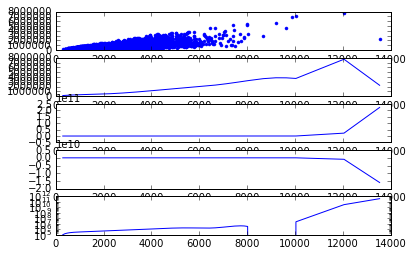

In [16]:
nrows= len(models)+1
ncols= 1
plt.subplots(nrows,ncols, sharex=True, sharey=True)
plt.subplot(nrows,ncols, 1)
plt.plot(sales['sqft_living'], sales['price'],'.')
for i, m in enumerate(models):
    plt.subplot(nrows,ncols,i+2)
    colName= "model"+str(i)
    plt.plot(sales['sqft_living'], sales[colName],'-')

plt.yscale('log')
plt.show()

The four curves should differ from one another a lot, as should the coefficients you learned.

***QUIZ QUESTION:  For the models learned in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?***  (For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

In [17]:
allCoeff.filter_by('power_01', 'name').sort('value')

Columns:
	name	str
	index	str
	value	float
	stderr	float
	model	int

Rows: 4

Data:
+----------+-------+----------------+---------------+-------+
|   name   | index |     value      |     stderr    | model |
+----------+-------+----------------+---------------+-------+
| power_01 |  None | -759.251894247 | 8955.93484765 |   2   |
| power_01 |  None | 585.865813792  | 3949.66696689 |   0   |
| power_01 |  None | 783.493739085  | 7477.52911259 |   1   |
| power_01 |  None | 1247.59033533  | 10667.8919582 |   3   |
+----------+-------+----------------+---------------+-------+
[4 rows x 5 columns]

### Quiz Question Answer:
* Smallest: -759.251894247
* Largest: 1247.59033533

# Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above. Also, make sure GraphLab Create doesn't create its own validation set by using the option `validation_set = None` in this call.

In [18]:
featureCol= 'sqft_living'
maxDegree= 15
targetCol= 'price'
l2_penalty= 1e5

In [19]:
models=[]
for dataset in datasets:
    target= dataset.copy()
    data= polynomial_sframe(target[featureCol],maxDegree)
    data[targetCol]= target[targetCol]
    
    model= graphlab.linear_regression.create(data,
                                            target=targetCol,
                                            l2_penalty=l2_penalty,
                                            l1_penalty=0.,
                                            validation_set=None,
                                            verbose=False)
    models.append(model)

In [20]:
for i,m in enumerate(models):
    colName= "model"+str(i)
    sales[colName]= m.predict(polynomial_sframe(sales['sqft_living'],15))

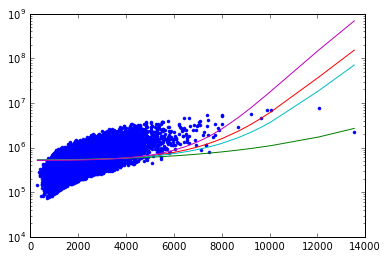

In [21]:
plt.plot(sales['sqft_living'], sales['price'], '.')
for i,m in enumerate(models):
    colName= "model"+str(i)
    plt.plot(sales['sqft_living'], sales[colName],'-')

plt.yscale('log')
plt.show()

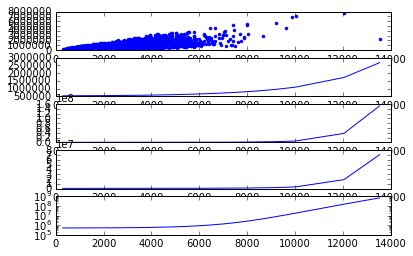

In [22]:
nrows= len(models)+1
ncols= 1
plt.subplots(nrows,ncols, sharex=True, sharey=True)
plt.subplot(nrows,ncols, 1)
plt.plot(sales['sqft_living'], sales['price'],'.')
for i, m in enumerate(models):
    plt.subplot(nrows,ncols,i+2)
    colName= "model"+str(i)
    plt.plot(sales['sqft_living'], sales[colName],'-')

plt.yscale('log')
plt.show()

These curves should vary a lot less, now that you applied a high degree of regularization.

***QUIZ QUESTION:  For the models learned with the high level of regularization in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?*** (For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

In [23]:
allCoeff= graphlab.SFrame()
for i,m in enumerate(models):
    f= m.get('coefficients')
    f['model']= i
    allCoeff= allCoeff.append(f)

In [24]:
allCoeff.filter_by('power_01', 'name').sort('value')

Columns:
	name	str
	index	str
	value	float
	stderr	float
	model	int

Rows: 4

Data:
+----------+-------+---------------+---------------+-------+
|   name   | index |     value     |     stderr    | model |
+----------+-------+---------------+---------------+-------+
| power_01 |  None | 1.91040938244 | 14106.9870403 |   3   |
| power_01 |  None | 2.04470474182 | 10305.6768827 |   1   |
| power_01 |  None | 2.26890421877 | 12484.6904649 |   2   |
| power_01 |  None | 2.58738875673 |  5943.7651897 |   0   |
+----------+-------+---------------+---------------+-------+
[4 rows x 5 columns]

# Quiz question answer
* Smallest: 1.91040938244
* Largest: 2.58738875673

# Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. GraphLab Create has a utility function for shuffling a given SFrame. We reserve 10% of the data as the test set and shuffle the remainder. (Make sure to use `seed=1` to get consistent answer.)

In [25]:
(train_valid, test) = sales.random_split(.9, seed=1)
train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)

Once the data is shuffled, we divide it into equal segments. Each segment should receive `n/k` elements, where `n` is the number of observations in the training set and `k` is the number of segments. Since the segment 0 starts at index 0 and contains `n/k` elements, it ends at index `(n/k)-1`. The segment 1 starts where the segment 0 left off, at index `(n/k)`. With `n/k` elements, the segment 1 ends at index `(n*2/k)-1`. Continuing in this fashion, we deduce that the segment `i` starts at index `(n*i/k)` and ends at `(n*(i+1)/k)-1`.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [26]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

intervals=[]
for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print i, (start, end), end-start+1
    intervals.append((start,end))

0 (0, 1938) 1939
1 (1939, 3878) 1940
2 (3879, 5817) 1939
3 (5818, 7757) 1940
4 (7758, 9697) 1940
5 (9698, 11636) 1939
6 (11637, 13576) 1940
7 (13577, 15515) 1939
8 (15516, 17455) 1940
9 (17456, 19395) 1940


Let us familiarize ourselves with array slicing with SFrame. To extract a continuous slice from an SFrame, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of `train_valid_shuffled`. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [27]:
cols= train_valid_shuffled.column_names()[0:3]
train_valid_shuffled[cols][0:10] # rows 0 to 9

Columns:
	id	str
	date	datetime
	price	float

Rows: 10

Data:
+------------+---------------------------+----------+
|     id     |            date           |  price   |
+------------+---------------------------+----------+
| 2780400035 | 2014-05-05 00:00:00+00:00 | 665000.0 |
| 1703050500 | 2015-03-21 00:00:00+00:00 | 645000.0 |
| 5700002325 | 2014-06-05 00:00:00+00:00 | 640000.0 |
| 0475000510 | 2014-11-18 00:00:00+00:00 | 594000.0 |
| 0844001052 | 2015-01-28 00:00:00+00:00 | 365000.0 |
| 2781280290 | 2015-04-27 00:00:00+00:00 | 305000.0 |
| 2214800630 | 2014-11-05 00:00:00+00:00 | 239950.0 |
| 2114700540 | 2014-10-21 00:00:00+00:00 | 366000.0 |
| 2596400050 | 2014-07-30 00:00:00+00:00 | 375000.0 |
| 4140900050 | 2015-01-26 00:00:00+00:00 | 440000.0 |
+------------+---------------------------+----------+
[10 rows x 3 columns]

Now let us extract individual segments with array slicing. Consider the scenario where we group the houses in the `train_valid_shuffled` dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above.
Extract the fourth segment (segment 3) and assign it to a variable called `validation4`.

In [28]:
intervalNum= 3
start= intervals[intervalNum][0]
end= intervals[intervalNum][1]+1
validation4= train_valid_shuffled[start:end]
len(validation4)

1940

To verify that we have the right elements extracted, run the following cell, which computes the average price of the fourth segment. When rounded to nearest whole number, the average should be $536,234.

In [29]:
print int(round(validation4['price'].mean(), 0))

536234


After designating one of the k segments as the validation set, we train a model using the rest of the data. To choose the remainder, we slice (0:start) and (end+1:n) of the data and paste them together. SFrame has `append()` method that pastes together two disjoint sets of rows originating from a common dataset. For instance, the following cell pastes together the first and last two rows of the `train_valid_shuffled` dataframe.

In [30]:
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print first_two.append(last_two)

+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 2780400035 | 2014-05-05 00:00:00+00:00 |  665000.0 |   4.0    |    2.5    |
| 1703050500 | 2015-03-21 00:00:00+00:00 |  645000.0 |   3.0    |    2.5    |
| 4139480190 | 2014-09-16 00:00:00+00:00 | 1153000.0 |   3.0    |    3.25   |
| 7237300290 | 2015-03-26 00:00:00+00:00 |  338000.0 |   5.0    |    2.5    |
+------------+---------------------------+-----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    2800.0   |   5900   |   1    |     0      |  0   |     3     |   8   |    1660    |
|    2490.0   |   59

Extract the remainder of the data after *excluding* fourth segment (segment 3) and assign the subset to `train4`.

In [31]:
intervalNum= 3
start= intervals[intervalNum][0]
end= intervals[intervalNum][1]+1
validation4= train_valid_shuffled[start:end]
train4= train_valid_shuffled[:start].append(train_valid_shuffled[end:])
print len(validation4), len(train4), len(validation4)+len(train4), len(train_valid_shuffled)

1940 17456 19396 19396


To verify that we have the right elements extracted, run the following cell, which computes the average price of the data with fourth segment excluded. When rounded to nearest whole number, the average should be $539,450.

In [32]:
print int(round(train4['price'].mean(), 0))

539450


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) name of output column (e.g. `price`) and (v) list of feature names. The function returns the average validation error using k segments as validation sets.

* For each i in [0, 1, ..., k-1]:
  * Compute starting and ending indices of segment i and call 'start' and 'end'
  * Form validation set by taking a slice (start:end+1) from the data.
  * Form training set by appending slice (end+1:n) to the end of slice (0:start).
  * Train a linear model using training set just formed, with a given l2_penalty
  * Compute validation error using validation set just formed

In [33]:
def define_intervals(k, data):
    n= len(data)
    
    intervals=[]
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        intervals.append((start,end))
    
    return intervals

In [34]:
def k_fold_cv_sets(i, intervals, data):
    start= intervals[i][0]
    end= intervals[i][1]
    
    validation= data[start:end+1]
    train= data[:start].append(data[end+1:])
    
    return validation, train

In [35]:
def k_fold_validation_error(i, intervals, data, features_list, output_name, l2_penalty):
    validation, train= k_fold_cv_sets(i, intervals, data)
    
    model= graphlab.linear_regression.create(train,
                                            features=features_list,
                                            target=output_name,
                                            l2_penalty=l2_penalty,
                                            validation_set=None,
                                            verbose=False)

    prediction= model.predict(validation)
    residual= validation[output_name]- prediction
    error= (residual*residual).sum()
    
    return model, error

In [36]:
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    intervals= define_intervals(k,data)
    result={}
    result['lambda']= l2_penalty
    
    models=[]
    results=[]
    coefficients=None
    for i in xrange(k):
        result['modelNumber']= i
        
        model, error= k_fold_validation_error(i, intervals, data, features_list, output_name, l2_penalty)
        result['error']= error
        
        models.append(model)
        resultTuple= (result['lambda'], result['modelNumber'], result['error'])
        results.append(resultTuple)
        
        coefficient= model.get('coefficients')
        coefficient['modelNumber']= i
        coefficient['lambda']= l2_penalty
        if i==0:
            coefficients= graphlab.SFrame(coefficient)
        else:
            coefficients= coefficients.append(coefficient)
            
            
    
    lambdas, modelNumbers, errors= zip(*results)
    results= graphlab.SFrame({'lambda': lambdas, 'modelnumber': modelNumbers, 'error': errors})
   
    return graphlab.SArray(errors).mean(), results, coefficients

In [37]:
error, results, coefficients= k_fold_cross_validation(10, 1e5, train_valid_shuffled, 'price', ['sqft_living'])
print error
print results
print coefficients

2.58844902676e+14
+-------------------+----------+-------------+
|       error       |  lambda  | modelnumber |
+-------------------+----------+-------------+
| 2.41735731153e+14 | 100000.0 |      0      |
| 2.47329626108e+14 | 100000.0 |      1      |
| 2.08152149757e+14 | 100000.0 |      2      |
| 2.52068149484e+14 | 100000.0 |      3      |
| 2.38496029355e+14 | 100000.0 |      4      |
| 2.84801020888e+14 | 100000.0 |      5      |
| 3.09521370852e+14 | 100000.0 |      6      |
| 2.80059778719e+14 | 100000.0 |      7      |
|  2.2080521806e+14 | 100000.0 |      8      |
| 3.05479952381e+14 | 100000.0 |      9      |
+-------------------+----------+-------------+
[10 rows x 3 columns]

+-------------+-------+---------------+---------------+-------------+----------+
|     name    | index |     value     |     stderr    | modelNumber |  lambda  |
+-------------+-------+---------------+---------------+-------------+----------+
| (intercept) |  None |  523912.98158 | 6831.69600311 |   

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: `np.logspace(1, 7, num=13)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use `train_valid_shuffled` when generating polynomial features!

In [38]:
f= polynomial_sframe(train_valid_shuffled['sqft_living'],15)
featuresList= f.column_names()
f['price']= train_valid_shuffled['price']

l2_penaltyList= np.logspace(1, 7, num=13)

In [39]:
errors=[]
results= graphlab.SFrame({})
coefficients= graphlab.SFrame({})
for l2_penalty in l2_penaltyList:
    error, result, coefficient= k_fold_cross_validation(10, l2_penalty, f, 'price', featuresList)
    
    errors.append(error)
    results= results.append(result)
    coefficients= coefficients.append(coefficient)
pass

In [40]:
resultsAvg= results.groupby(key_columns=['lambda'], operations={'error': graphlab.aggregate.MEAN('error')}).sort('lambda')
coeffAvg= coefficients.groupby(key_columns=['lambda','name'], operations={'value': graphlab.aggregate.MEAN('value')}).sort('lambda')

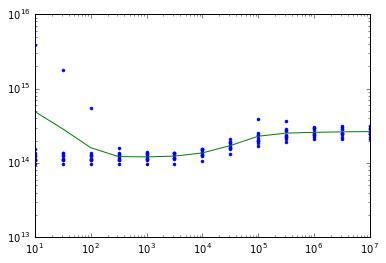

In [41]:
plt.loglog(results['lambda'], results['error'],'.')
plt.loglog(resultsAvg['lambda'], resultsAvg['error'],'-')

In [42]:
variableList= coefficients['name'].unique()
variableList= sorted(variableList)

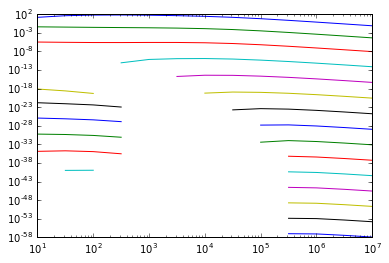

In [43]:
for n in variableList:
    if n=='(intercept)': continue
    plotDataAvg= coeffAvg.filter_by(n, 'name')
    plt.loglog(plotDataAvg['lambda'], plotDataAvg['value'],'-')

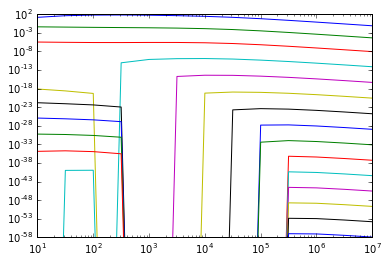

In [44]:
for n in variableList:
    if n=='(intercept)': continue
    plotDataAvg= coeffAvg.filter_by(n, 'name')
    plt.semilogx(plotDataAvg['lambda'], plotDataAvg['value'],'-')
plt.yscale('log')

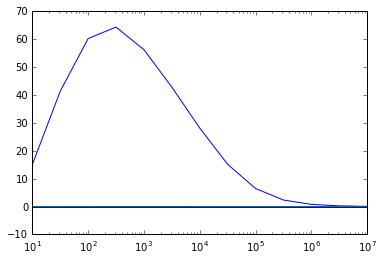

In [45]:
for n in variableList:
    if n=='(intercept)': continue
    plotDataAvg= coeffAvg.filter_by(n, 'name')
    plt.semilogx(plotDataAvg['lambda'], plotDataAvg['value'],'-')

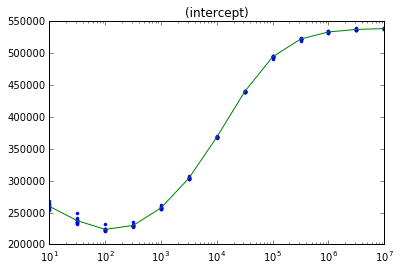

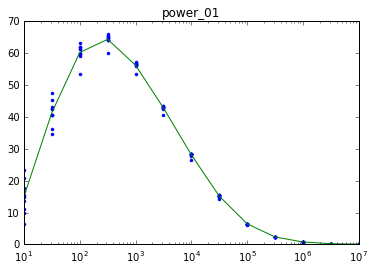

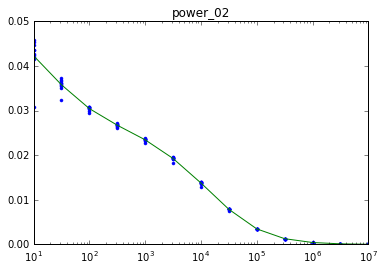

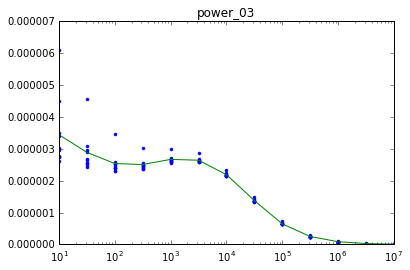

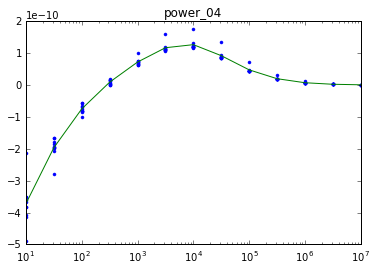

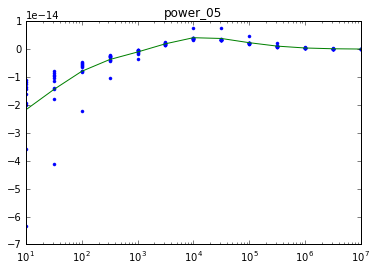

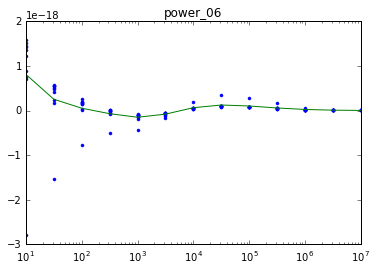

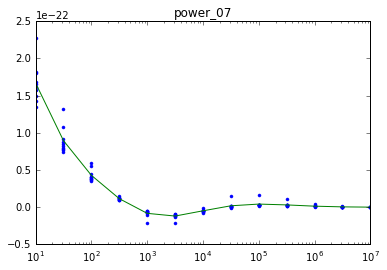

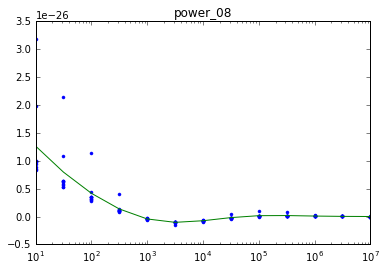

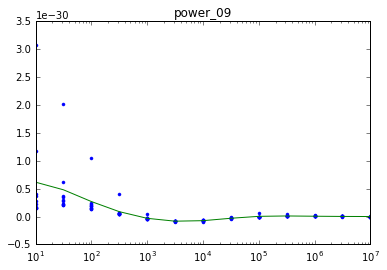

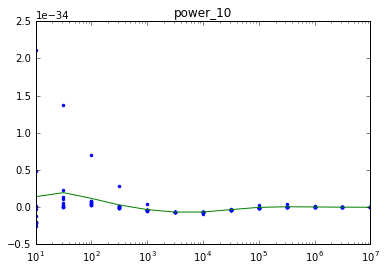

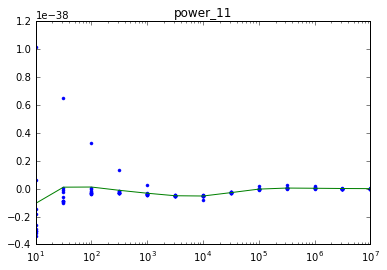

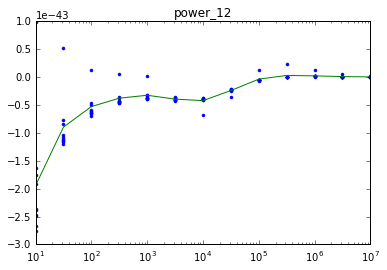

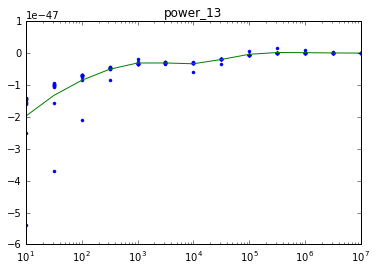

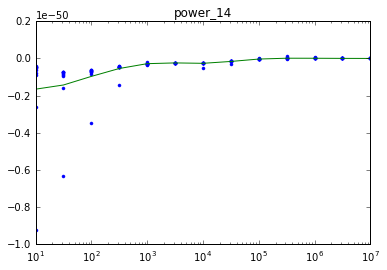

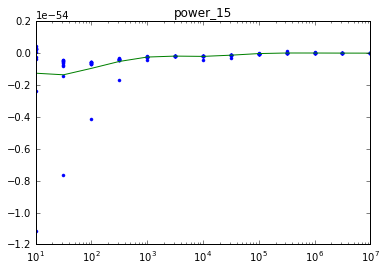

In [46]:
for n in variableList:
    plotData= coefficients.filter_by(n, 'name')
    plotDataAvg= coeffAvg.filter_by(n, 'name')
    #print plotData.head()
    plt.semilogx(plotData['lambda'], plotData['value'],'.')
    plt.semilogx(plotDataAvg['lambda'], plotDataAvg['value'],'-')
    plt.title(n)
    plt.show()

***QUIZ QUESTIONS:  What is the best value for the L2 penalty according to 10-fold validation?***

In [47]:
l2_penaltyList[np.argmin(errors)]

1000.0

###### Quiz Question Answer

* 1000 is the best L2 penalty

You may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method.  

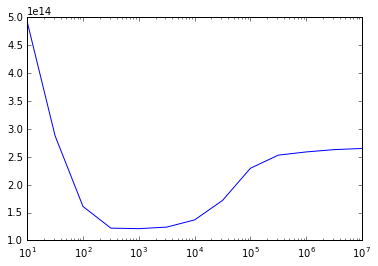

In [48]:
plt.plot(l2_penaltyList, errors, '-')
plt.xscale('log')
plt.show()

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`. This way, your final model will be trained on the entire dataset.

In [49]:
data= polynomial_sframe(train_valid['sqft_living'],15)
data['price']= train_valid['price']

model= graphlab.linear_regression.create(data, target='price', l2_penalty=1000.0, validation_set=None, verbose=False)

***QUIZ QUESTION: Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty? ***

In [51]:
residuals= model.predict(test)-test['price']
rss= (residuals*residuals).sum()
print int(floor(log(rss)))
print rss

33
2.52897427447e+14
